# Estimate car price - Train Model

### Introduction
-  Learn from previous sales of used cars to estimate price of further used vehicles
-  Push calculations down to SAP HANA. Leverage the in-memory performance directly out of Python without data extraction.

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/2cfbc5cf2bc14f028cfbe2a2bba60a50/latest/en-US/f652a8186a144e929a1ade7a3cb7abe8.html
-  Dataset: https://www.kaggle.com/bozungu/ebay-used-car-sales-data

### Create a HANA DataFrame, which points to the prepared view. The data remains in SAP HANA.

In [1]:
# Obtain logon details from the central Connection Management of SAP Data Intelligence
import hana_ml.dataframe as dataframe

# Instantiate connection object
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId='HANADB')

# Create the HANA dataframe in the structure of the specified table
df_pushdown = conn.table("USEDCARPRICES_PREP_VIEW", schema="TAXX")

### Split data into train and test

In [2]:
# Add single character from hash
df_pushdown_hash = df_pushdown.select(('SUBSTR (CAST(HASH_SHA256(to_binary("CAR_ID")) AS VARCHAR), 1, 1)', 
                                                'CAR_ID_HASH'), df_pushdown.columns)

In [3]:
# Specify split / filter criteria
row_filter = "'0', '1', '2'"  # out of 16, from 0 to F. 3 out of 16 averages to 18.75%

# Split data by applying filter
# example: df_pushdown_train = df_pushdown_hash.filter('"CAR_ID_HASH" NOT IN (\'0\', \'1\', \'2\')')
df_pushdown_train = df_pushdown_hash.filter('"CAR_ID_HASH" NOT IN (' + row_filter + ')').drop(["CAR_ID_HASH"])
df_pushdown_test = df_pushdown_hash.filter('"CAR_ID_HASH" IN (' + row_filter + ')').drop(["CAR_ID_HASH"])

print("Training size: " + str(df_pushdown_train.count()))
print("Test size: " + str(df_pushdown_test.count()))

Training size: 14878
Test size: 3455


### Train decision tree regression

In [4]:
from hana_ml.algorithms.pal import trees
tree_reg = trees.DecisionTreeRegressor(conn_context=conn, 
                                   algorithm='cart',
                                   min_records_of_parent=10,
                                   min_records_of_leaf=1,
                                   thread_ratio=0.4,
                                   split_threshold=1e-5,
                                   model_format='json',
                                   output_rules=True)

# Specify the tree's predictors
features = ['GEARBOX_IMP', "VEHICLETYPE", "YEAR", "MODEL", "HP", "FUELTYPE", "KILOMETER", "DAMAGED"]

# Train the tree
tree_reg.fit(df_pushdown_train, key="CAR_ID", label="PRICE", features=features)

### Show decision tree logic 
(only very small part of the whole tree)

In [5]:
df_rules = tree_reg.decision_rules_.head(1).collect()

# First rule
df_rules.iloc[0,1]

'(YEAR<2008.5) && (HP>=218.5) && ((MODEL=GLK)||(MODEL=GL)||(MODEL=SL)||(MODEL=G-Class)) && (HP>=310.5) && (HP>=512.5) => 46357.8'

### Training set: Quality metric (R^2)

In [6]:
print("R'2 on train data: " + str(tree_reg.score(df_pushdown_train, key="CAR_ID")))

R'2 on train data: 0.941402383694653


### Test set: Compare Actuals with Predictions

In [7]:
df_pushdown_act_pred = df_pushdown_test.alias('L').join(
    tree_reg.predict(df_pushdown_test, features=features, key="CAR_ID").alias('R'),
    '"L"."CAR_ID" = "R"."CAR_ID"', 
    select=[('"L"."CAR_ID"', 'CAR_ID'), "MODEL", ('"PRICE"','ACTUALS'), ('"SCORE"', 'PREDICTIONS')])

In [8]:
df_pushdown_act_pred.head(5).collect()

,CAR_ID,MODEL,ACTUALS,PREDICTIONS
0,272,C-Class,5000.0,3679.94
1,378,C-Class,1700.0,2692.72
2,386,C-Class,3799.0,2692.72
3,394,C-Class,2499.0,3679.94
4,1055,C-Class,10300.0,9733.61


In [9]:
df_pushdown_act_pred.select_statement

'SELECT "L"."CAR_ID" AS "CAR_ID", "MODEL", "PRICE" AS "ACTUALS", "SCORE" AS "PREDICTIONS" FROM (SELECT "GEARBOX_IMP", "CAR_ID", "VEHICLETYPE", "NAME", "MODEL", "YEAR", "HP", "FUELTYPE", "KILOMETER", "DAMAGED", "PRICE" FROM (SELECT * FROM (SELECT SUBSTR (CAST(HASH_SHA256(to_binary("CAR_ID")) AS VARCHAR), 1, 1) AS "CAR_ID_HASH", "GEARBOX_IMP", "CAR_ID", "VEHICLETYPE", "NAME", "MODEL", "YEAR", "HP", "FUELTYPE", "KILOMETER", "DAMAGED", "PRICE" FROM (SELECT * FROM "TA60"."USEDCARPRICES_PREP_VIEW") AS "DT_0") AS "DT_1" WHERE "CAR_ID_HASH" IN (\'0\', \'1\', \'2\')) AS "DT_4") AS "L" INNER JOIN (SELECT * FROM "#PAL_DECISION_TREE_RESULT_TBL_0_02E5C5AE_CFE3_11E9_ACAD_0A4E9FFB99DE") AS "R" ON "L"."CAR_ID" = "R"."CAR_ID"'

### Test set: Quality metric (Root Mean Squared Error) 

In [10]:
# Calculate in SAP HANA
import numpy as np
df_pushdown_se = df_pushdown_act_pred.select('CAR_ID', 'MODEL', 'ACTUALS', 'PREDICTIONS', ('(ACTUALS - PREDICTIONS) * (ACTUALS - PREDICTIONS) ', 'ERRORSQ'))
df_mse = df_pushdown_se.agg([('avg', 'ERRORSQ', 'MSE')]).collect()
rmse = np.sqrt(float(df_mse.iloc[0:,0]))
print("RMSE: " + str(round(rmse, 2)))

RMSE: 3015.31


### Error Analysis by car model

In [11]:
df_mse = df_pushdown_se.agg([('avg', 'ERRORSQ', 'MSE')], group_by=['MODEL']).collect()
df_mse["RMSE"] = np.sqrt(df_mse["MSE"])
df_mse.sort_values(by=['RMSE'], ascending = False)

,MODEL,MSE,RMSE
16,G-Class,1.022071e+08,10109.750939
10,SL,8.383365e+07,9156.072028
17,V-Class,7.709792e+07,8780.542309
12,GL,2.758510e+07,5252.152237
11,Viano,1.840250e+07,4289.813733
15,GLK,1.487161e+07,3856.372782
9,M-Class,1.434625e+07,3787.644561
7,CL,1.417132e+07,3764.480712
8,S-Class,1.398648e+07,3739.850779
5,Other,1.258669e+07,3547.772718


### Grid search for hyperparameters

In [12]:
min_records_of_parent = [1, 2, 3, 4, 5, 7, 10]
min_records_of_leaf = [1, 2, 3, 5]

In [16]:
#!pip install sklearn

In [17]:
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

# Dataframe to store hyperparameters with model quality
df_hyper_quality = pd.DataFrame(columns=['MIN_RECORDS_OF_PARENT', 'MIN_RECORDS_OF_LEAF', 'RMSE'])

# Iterate through all combinations
from hana_ml.algorithms.pal import trees
for aa in min_records_of_parent:
    for bb in min_records_of_leaf:
        tree_reg = trees.DecisionTreeRegressor(conn_context=conn,
                                   algorithm='cart',
                                   min_records_of_parent=aa,
                                   min_records_of_leaf=bb,
                                   thread_ratio=0.4,
                                   split_threshold=1e-5,
                                   model_format='json',
                                   output_rules=True)

        # Train the tree
        tree_reg.fit(df_pushdown_train, features=features, key="CAR_ID", label='PRICE')

        print("min_records_of_parent: ", aa, " | min_records_of_leaf: ", bb)
        
        df_pushdown_act_pred = df_pushdown_test.alias('L').join(
            tree_reg.predict(df_pushdown_test, features=features, key="CAR_ID").alias('R'),
            '"L"."CAR_ID" = "R"."CAR_ID"', 
            select=[('"L"."CAR_ID"', 'CAR_ID'), ('"PRICE"','ACTUALS'), ('"SCORE"', 'PREDICTIONS')])
        df_act_pred = df_pushdown_act_pred.select("ACTUALS", "PREDICTIONS").collect()
        rmse = sqrt(mean_squared_error(df_act_pred.loc[:,"ACTUALS"], df_act_pred.loc[:,"PREDICTIONS"]))
        print("RMSE on test data: " + str(round(rmse, 2)))
        print()
        
        # Add to hyperparameter store
        df_hyper_quality = df_hyper_quality.append({'MIN_RECORDS_OF_PARENT': aa, 'MIN_RECORDS_OF_LEAF': bb, 'RMSE': rmse}, ignore_index = True)
        
print("Done")

min_records_of_parent:  1  | min_records_of_leaf:  1
RMSE on test data: 3211.09

min_records_of_parent:  1  | min_records_of_leaf:  2
RMSE on test data: 3100.86

min_records_of_parent:  1  | min_records_of_leaf:  3
RMSE on test data: 3094.47

min_records_of_parent:  1  | min_records_of_leaf:  5
RMSE on test data: 3152.21

min_records_of_parent:  2  | min_records_of_leaf:  1
RMSE on test data: 3211.09

min_records_of_parent:  2  | min_records_of_leaf:  2
RMSE on test data: 3100.86

min_records_of_parent:  2  | min_records_of_leaf:  3
RMSE on test data: 3094.47

min_records_of_parent:  2  | min_records_of_leaf:  5
RMSE on test data: 3152.21

min_records_of_parent:  3  | min_records_of_leaf:  1
RMSE on test data: 3214.78

min_records_of_parent:  3  | min_records_of_leaf:  2
RMSE on test data: 3100.86

min_records_of_parent:  3  | min_records_of_leaf:  3
RMSE on test data: 3094.47

min_records_of_parent:  3  | min_records_of_leaf:  5
RMSE on test data: 3152.21

min_records_of_parent:  4  |

### Model quality by hyperparameters

In [18]:
df_hyper_quality["MIN_RECORDS_OF_PARENT"] = df_hyper_quality["MIN_RECORDS_OF_PARENT"].astype(int)
df_hyper_quality["MIN_RECORDS_OF_LEAF"] = df_hyper_quality["MIN_RECORDS_OF_LEAF"].astype(int)
df_hyper_quality.sort_values(by="RMSE", ascending=True).head(10)

,MIN_RECORDS_OF_PARENT,MIN_RECORDS_OF_LEAF,RMSE
24,10,1,3015.310106
20,7,1,3055.063872
21,7,2,3068.079992
25,10,2,3072.895843
26,10,3,3078.565759
17,5,2,3081.485788
22,7,3,3087.064269
18,5,3,3094.472212
14,4,3,3094.472212
2,1,3,3094.472212


In [19]:
# Reshape data for heatmap
df_hyper_matrix = df_hyper_quality.pivot(index="MIN_RECORDS_OF_PARENT", columns="MIN_RECORDS_OF_LEAF", values="RMSE")
df_hyper_matrix = df_hyper_matrix.sort_index(axis=0, ascending=False)

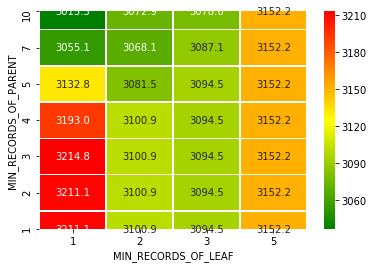

In [20]:
# Plot heatmap on model quality
%matplotlib inline 
import seaborn as sns
import matplotlib 

# Configuration
traffic_light = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
sns.heatmap(df_hyper_matrix, cmap=traffic_light, linewidths=.5, 
           robust=True, annot=True, fmt=".1f", xticklabels=df_hyper_matrix.columns.values.round(2));

### Save model to SAP HANA table

In [21]:
model = tree_reg.model_.select('ROW_INDEX', 'MODEL_CONTENT')
model.save(("TAXX", "USEDCARPRICES_MODEL_REGTREE"))

### Close connection

In [22]:
conn.close()